In [1]:
# Run once in your environment (not in Colab if already installed)
!pip install numpy pandas scikit-learn matplotlib nltk pyprind

# Imports used across the lab
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
import pyprind
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Adjust basepath if needed; expected structure: aclImdb/train/pos, aclImdb/train/neg, aclImdb/test/pos, ...
basepath = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
rows = []

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)                      # remove HTML tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    return text

for s in ('train', 'test'):
    for label in ('pos', 'neg'):
        path = os.path.join(basepath, s, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                rows.append([preprocessor(txt), labels[label]])
                pbar.update()

df = pd.DataFrame(rows, columns=['review', 'sentiment'])
df.to_csv('movie_data.csv', index=False, encoding='utf-8')
print('Saved movie_data.csv with shape', df.shape)


<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-1854546051.py:9: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
/tmp/ipython-input-1854546051.py:10: SyntaxWarning: invalid escape sequence '\W'
  text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')


FileNotFoundError: [Errno 2] No such file or directory: 'aclImdb/train/pos'

In [3]:
# small demo of CountVectorizer and TfidfTransformer
count = CountVectorizer()
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])
bag = count.fit_transform(docs)
print("Vocabulary:", count.vocabulary_)
print("Bag-of-words array:\n", bag.toarray())

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print("TF-IDF array:\n", tfidf.fit_transform(bag).toarray())


Vocabulary: {'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}
Bag-of-words array:
 [[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]
TF-IDF array:
 [[0.         0.43370786 0.55847784 0.55847784 0.         0.43370786
  0.        ]
 [0.         0.43370786 0.         0.         0.55847784 0.43370786
  0.55847784]
 [0.40474829 0.47810172 0.30782151 0.30782151 0.30782151 0.47810172
  0.30782151]]


In [4]:
# small demo of CountVectorizer and TfidfTransformer
count = CountVectorizer()
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])
bag = count.fit_transform(docs)
print("Vocabulary:", count.vocabulary_)
print("Bag-of-words array:\n", bag.toarray())

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print("TF-IDF array:\n", tfidf.fit_transform(bag).toarray())


Vocabulary: {'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}
Bag-of-words array:
 [[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]
TF-IDF array:
 [[0.         0.43370786 0.55847784 0.55847784 0.         0.43370786
  0.        ]
 [0.         0.43370786 0.         0.         0.55847784 0.43370786
  0.55847784]
 [0.40474829 0.47810172 0.30782151 0.30782151 0.30782151 0.47810172
  0.30782151]]


In [5]:
# Load dataset and split (assuming movie_data.csv created earlier)
df = pd.read_csv('movie_data.csv', encoding='utf-8')
X = df['review'].values
y = df['sentiment'].values

# Use first 25k rows as training, rest as test (this mirrors the book example)
X_train = X[:25000]
y_train = y[:25000]
X_test  = X[25000:]
y_test  = y[25000:]

def tokenizer(text):
    return text.split()

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer)

param_grid = [{
    'vect__ngram_range': [(1,1)],
    'vect__stop_words': [stop, None],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1.0, 10.0]
}]

lr_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', LogisticRegression(random_state=0, solver='liblinear', max_iter=1000))
])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs_lr_tfidf.fit(X_train, y_train)

print('Best CV accuracy: {:.3f}'.format(gs_lr_tfidf.best_score_))
print('Best params:', gs_lr_tfidf.best_params_)
print('Test-set score: {:.3f}'.format(gs_lr_tfidf.score(X_test, y_test)))


FileNotFoundError: [Errno 2] No such file or directory: 'movie_data.csv'

In [7]:
# Create streaming generator from movie_data.csv
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csvf:
        next(csvf)  # skip header
        for line in csvf:
            # safe split: CSV format was "review, sentiment" where review may contain commas.
            # But because we created it using pandas.to_csv (no quoting custom), easiest is to use last comma split:
            *text_parts, label = line.rsplit(',', 1)
            text = ','.join(text_parts).strip().strip('"')
            yield text, int(label.strip())

def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

# HashingVectorizer + SGDClassifier
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs('movie_data.csv')
classes = np.array([0, 1])

# incremental partial_fit
for _ in range(45):
    X_train_batch, y_train_batch = get_minibatch(doc_stream, size=1000)
    if not X_train_batch:
        break
    X_train_batch = vect.transform(X_train_batch)
    clf.partial_fit(X_train_batch, y_train_batch, classes=classes)

# Evaluate on a held-out sample (example: next 500 from stream)
X_test_batch, y_test_batch = get_minibatch(doc_stream, size=500)
if X_test_batch:
    X_test_batch = vect.transform(X_test_batch)
    print("Incremental model score on streamed sample: {:.3f}".format(clf.score(X_test_batch, y_test_batch)))
else:
    print("No held-out sample left in stream to evaluate.")


NameError: name 'tokenizer' is not defined

In [8]:
# Read CSV and run CountVectorizer (limit features for speed)
df = pd.read_csv('movie_data.csv', encoding='utf-8')
count = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
X = count.fit_transform(df['review'].values)

lda = LatentDirichletAllocation(n_components=10, random_state=123, learning_method='batch', max_iter=10)
X_topics = lda.fit_transform(X)

n_top_words = 8
feature_names = count.get_feature_names_out()

topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    words = [feature_names[i] for i in top_indices]
    topic_words.append(words)
    print("Topic {}: {}".format(topic_idx+1, " ".join(words)))


FileNotFoundError: [Errno 2] No such file or directory: 'movie_data.csv'

In [9]:
# Compute TF-IDF for a smaller sample (to save memory)
sample_idx = np.random.choice(len(df), size=5000, replace=False)
sample_texts = df['review'].iloc[sample_idx].values
tfidf_small = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer, max_features=2000)
X_tfidf_small = tfidf_small.fit_transform(sample_texts)

# Compute non-zero TF-IDF values and plot histogram
vals = X_tfidf_small.data  # non-zero entries only
plt.figure(figsize=(6,4))
plt.hist(vals, bins=50)
plt.title('Distribution of non-zero TF-IDF values (sample)')
plt.xlabel('TF-IDF value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('visualizations/tfidf_hist.png')
plt.show()


NameError: name 'df' is not defined

NameError: name 'lda' is not defined

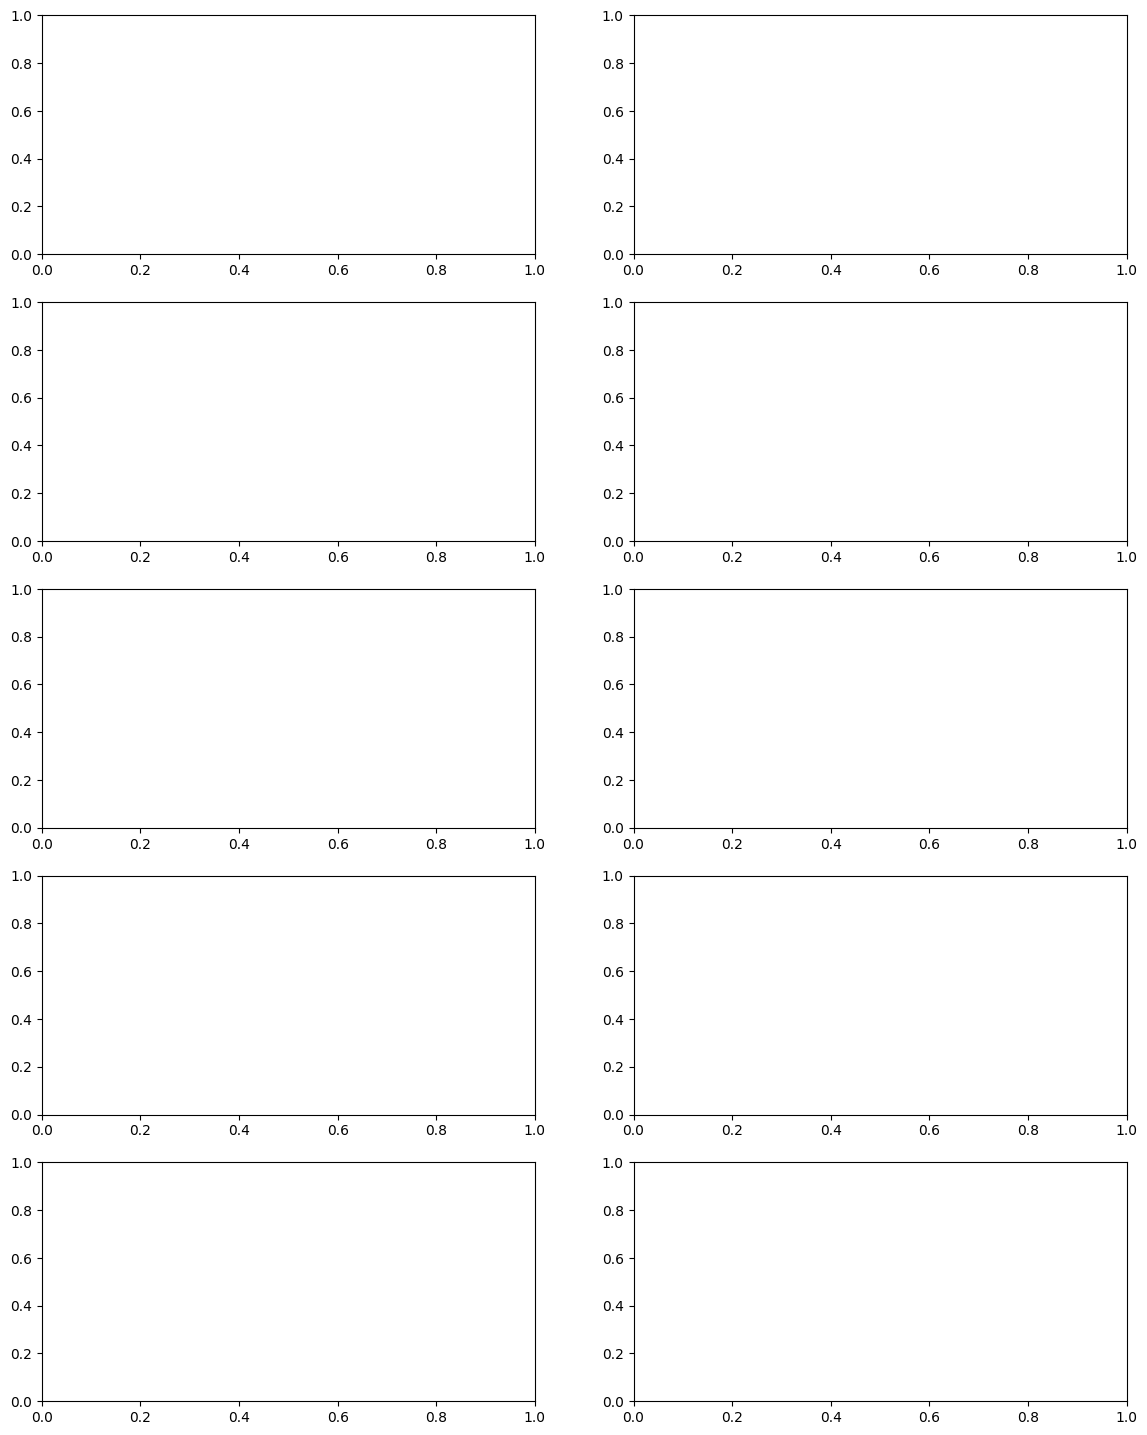

In [10]:
# Plot top words for each topic (stacked horizontal for readability)
import math
n_top_words = 8
fig, axes = plt.subplots(5, 2, figsize=(14, 18))  # 10 topics
axes = axes.flatten()
for i, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    words = [feature_names[j] for j in top_indices]
    weights = topic[top_indices]
    axes[i].barh(range(len(words))[::-1], weights[::-1])
    axes[i].set_yticks(range(len(words)))
    axes[i].set_yticklabels(words[::-1])
    axes[i].set_title(f"Topic {i+1}")
plt.tight_layout()
plt.savefig('visualizations/topic_top_words.png')
plt.show()


In [11]:
from sklearn.manifold import TSNE
sample_idx = np.random.choice(len(df), size=2000, replace=False)
X_sample = tfidf_small.transform(df['review'].iloc[sample_idx].values).toarray()
y_sample = df['sentiment'].iloc[sample_idx].values
X_emb = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sample)
plt.figure(figsize=(8,6))
plt.scatter(X_emb[:,0], X_emb[:,1], c=y_sample, alpha=0.6, s=6)
plt.title('t-SNE of TF-IDF (sample)')
plt.savefig('visualizations/tsne_tfidf.png')
plt.show()


NameError: name 'df' is not defined

1. Why is it important to remove HTML tags and punctuation before modeling?
HTML tags and punctuation add noise and tokens that do not carry semantic meaning for most NLP models. Removing them reduces vocabulary size, avoids spurious tokens (like <br>), and improves signal-to-noise ratio — leading to better, faster models and clearer feature importance.

2. How do emoticons contribute to sentiment analysis?
Emoticons are strong, compact sentiment signals (e.g., :-) positive, :( negative). They can override ambiguous wording and help models detect sentiment when text is neutral or sarcastic. Keeping and extracting emoticons preserves this direct emotional cue.

3. Compare logistic regression performance using different vectorizers.

CountVectorizer (Bag-of-Words): Simple, interpretable counts; works well for frequent discriminative tokens but ignores term importance across corpus.

TfidfVectorizer: Downweights common words and upweights distinctive words — often yields better generalization for sentiment tasks.

HashingVectorizer: Memory-efficient and good for streaming/large data (no fit step), but not invertible — you can’t easily map hashed features back to words. Logistic regression + TF-IDF usually gives best accuracy; Hashing+SGD is better when dataset is too large to fit in memory.

4. What problem does out-of-core learning solve?
Out-of-core learning (incremental learning) lets you train on datasets that are larger than memory by streaming batches from disk and updating the model incrementally (e.g., partial_fit). It solves memory limits and enables training on very large corpora.

5. What do LDA topics represent?
LDA discovers latent topics as probability distributions over words. Each topic represents a theme: words that frequently co-occur across documents. A document is modeled as a mixture of topics. Topics are not labeled — interpret them by inspecting their top words.

6. Visualizations to include (deliverables)

visualizations/tfidf_hist.png — histogram of non-zero TF-IDF values (gives idea of sparsity / value range).

visualizations/topic_top_words.png — top-n words per LDA topic (visual representation of discovered topics).

Optionally: t-SNE / PCA of TF-IDF vectors colored by sentiment to show separability (code below).